# **Análisis exploratorio conjuntos de datos:**

A continuación, se detallan los conjuntos de datos que se van a utilizar para la creación, entrenamiento y validación del modelo de Machine Learning. Estos consisten en los siguientes, con sus respectivos orígenes:

- [Climatic Prediction Center](https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php).
    - [Índice Oceánico del Niño](https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt).
- [Parámetros técnicos del SIN (PARATEC)](https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt).
    - [Información técnica de Embalses](https://paratecbackend.xm.com.co/reportehidrologia/api/Hydrology/ReservoirInfo).
- [Sistema de Información para el Mercado de Energía Mayorista](https://www.simem.co/).
    - [Listado de Embalses que sirven al Sistema Interconectado Nacional](https://www.simem.co/datadetail/A0CF2AC0-ACEA-4154-A4DE-2928901CB5D0).
    - [Reservas Hidráulicas en Energía](https://www.simem.co/datadetail/B0E93334-D812-42A7-94FC-3F100BCE7038).
    - [Aportes Hídricos en Energía](https://www.simem.co/datadetail/BA1C5513-7DC3-4155-9DE9-D262863B31F3).

Para cada uno de estos se realizará un análisis exploratorio de sus variables categóricas y numéricas.


## **Climatic Prediction Center**

### **Indice Oceanico del Niño:**

| Columna | Descripción | Tipo de dato |
|---------|-------------|--------------|
|   Date  |  Fecha intermedia donde se calculo el valor del SST           |     Date         |
|   SST   |  Promedio movil de tres meses consecutivos de la temperatura superficial del mar en la zona de analisis del fenomeno del niño  |       float       |
|   ANOM  |  Indice ocenico del Niño que es el promedio de anomalías de temperatura en tres meses consecutivos   |  float            |


## **Importar librerias:**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.seasonal import seasonal_decompose
import sys
from datetime import date
import warnings
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests

sys.path.append(os.path.dirname(os.path.abspath('../../src')))

from src.GetData.ONI import DataOni
from src.GetData.SIMEM import DataSIMEM
from src.GetData.PARATEC import DataPARATEC 
from src.Analysis.TransformData import JoinData
from src.GetData.funciones import multiple_plot

warnings.filterwarnings("ignore")

## **Obtener Información de sistemas:** 

In [4]:
# Se utilizan las clases desarrolladas para guardar la infromacion limpia a rutas temporales

DataOni().save_oni_data(os.path.abspath("../../Data/Cleansed/ONI/ONI_historico.xlsx"))
DataPARATEC().save_paratec_data(os.path.abspath(f'../../Data/Cleansed/PARATEC/PARATEC_{ date.today()}.xlsx'))
data_sets = {
            'B0E933': pd.read_excel(os.path.abspath('../../Data/Raw/SIMEM/ReservasHidraulicasEnergía.xlsx')),
            'A0CF2A': pd.read_excel(os.path.abspath('../../Data/Raw/SIMEM/ListadoEmbalses.xlsx')),
            'BA1C55': pd.read_excel(os.path.abspath('../../Data/Raw/SIMEM/AportesHidricos.xlsx'))
        }
simem = DataSIMEM(data_sets=data_sets)
simem.save_simem_data('../../Data')

{'B0E933':              Fecha CodigoEmbalse RegionHidrologica  VolumenUtilDiarioEnergia  \
 0       2013-01-31         PENOL         Antioquia                2566134800   
 1       2013-01-31       CALIMA1             Valle                 140015200   
 2       2013-01-31      SALVAJIN             Valle                  84916700   
 3       2013-01-31        PORCE3         Antioquia                  26562300   
 4       2013-01-31         URRA1            Caribe                 117889500   
 ...            ...           ...               ...                       ...   
 106467  2025-03-23        PORCE2         Antioquia                  57267000   
 106468  2025-03-23        GUAVIO           Oriente                 538936200   
 106469  2025-03-23         PRADO            Centro                  50471900   
 106470  2025-03-23        PLAYAS         Antioquia                 109181100   
 106471  2025-03-23      MIRAFLOR         Antioquia                         0   
 
         Capacid

In [5]:
# # En caso de sacar la infrormacion directamente se SIMEM puede usar el siguiente bloque de codigo

# simem = DataSIMEM()
# simem.save_simem_data('../../Data')

#### **Cargar conjuntos de datos:**

In [6]:
file_path = os.path.abspath("../../Data/Cleansed/ONI/ONI_historico.xlsx")


# Cargar el archivo de datos
data = pd.read_excel(file_path)

# Mostrar las primeras filas del DataFrame
data.head()


,Date,SST,ANOM
0,1950-01-01,24.72,-1.53
1,1950-02-01,25.17,-1.34
2,1950-03-01,25.75,-1.16
3,1950-04-01,26.12,-1.18
4,1950-05-01,26.32,-1.07


### **Descripción del conjunto de datos:**

In [112]:
data.describe()

,Date,SST,ANOM
count,903,903.000000,903.000000
mean,1987-08-01 11:44:51.029900352,26.904352,0.012315
min,1950-01-01 00:00:00,24.380000,-2.030000
25%,1968-10-16 12:00:00,26.230000,-0.570000
50%,1987-08-01 00:00:00,26.950000,-0.050000
75%,2006-05-16 12:00:00,27.540000,0.530000
max,2025-03-01 00:00:00,29.260000,2.640000
std,NaN,0.942695,0.835370


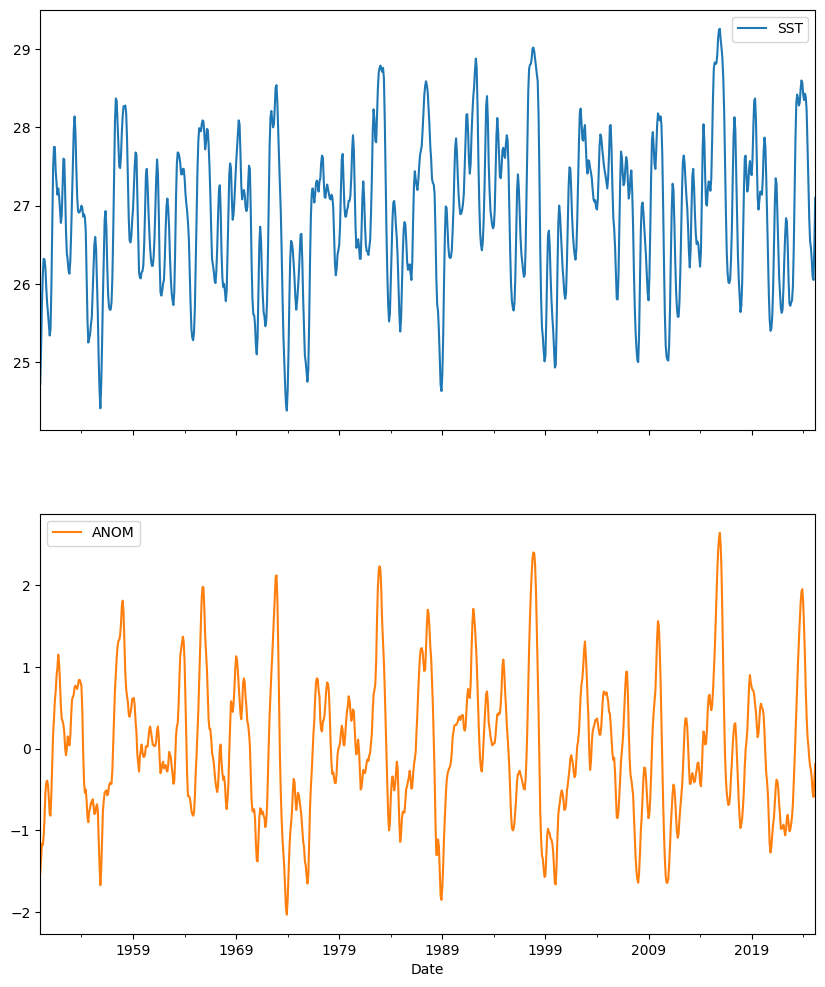

In [113]:
# Plotting all numerical variables over time
data.set_index('Date').plot(subplots=True, figsize=(10, 12))
plt.show()


### **Analisis de estacionalidad:**

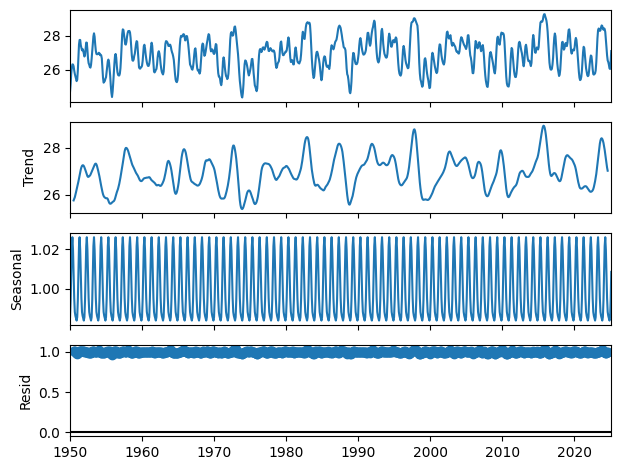

In [116]:
# Descomposición de la serie temporal
decomposition = seasonal_decompose(data[['Date','SST']].set_index('Date'), model='multiplicative')
decomposition.plot()
plt.show()


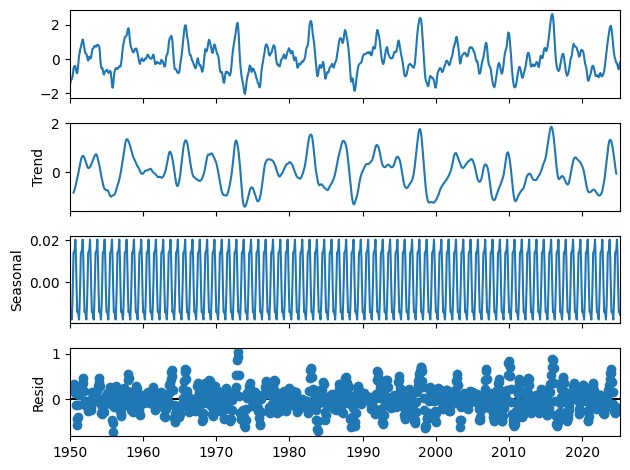

In [117]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Descomposición de la serie temporal es aditiva dado a que tiene el cero
decomposition = seasonal_decompose(data[['Date','ANOM']].set_index('Date'), model='additive')
decomposition.plot()
plt.show()

## **Parámetros técnicos del SIN (PARATEC):**

### **Información técnica de Embalses:**

#### **Cargar conjuntos de datos:**

In [118]:
file_path = os.path.abspath("../../Data/Cleansed/PARATEC/PARATEC_2025-05-17.xlsx")

# Load the data from the Excel file
data = pd.read_excel(file_path)

# Display the first few rows of the DataFrame
data.head()


,reservoir,latitude,longitude
0,ESMERALDA,4.900000,-73.300000
1,CALIMA,3.524585,-76.333665
2,PRADO,3.451501,-74.531129
3,SALVAJINA,2.563915,-76.422730
4,ALTOANCHICAYA,3.320507,-76.521748


### **Descripción del conjunto de datos:**

In [119]:
# Imprimir el resumen del DataFrame
data.describe()

,latitude,longitude
count,29.000000,29.000000
mean,5.334562,-74.840935
std,1.556431,1.008439
min,2.423000,-76.521748
25%,4.342150,-75.452425
50%,5.370000,-75.139300
75%,6.519072,-73.985400
max,7.866667,-73.290070


## **Sistema de Información para el Mercado de Energía Mayorista:**

### **Listado de Embalses que sirven al Sistema Interconectado Nacional:**

| Columna | Descripción | Tipo de dato |
|---------|-------------|--------------|
|   CodigoEmbalse  |  Código del embalse           |    str         |
|   NombreEmbalse   |  Nombre de los embalses del sistema interconectado nacional.  |       str       |


#### **Cargar conjuntos de datos:**

In [5]:
file_path = os.path.abspath("../../Data/Cleansed/SIMEM/ListadoEmbalses.xlsx")

# Cargar el archivo de datos
data = pd.read_excel(file_path)

# Mostrar las primeras filas del DataFrame
data.head()


,CodigoEmbalse,NombreEmbalse
0,PRADO,PRADO
1,MIRATRON,AGREGADO MIRAFLORES - TRONERAS
2,NEUSA,NEUSA
3,ELQUIMBO,EL QUIMBO
4,AGRESIN,AGREGADO_SIN


### **Descripción del conjunto de datos:**

In [121]:
data.describe()

,Fecha,CodigoEmbalse,NombreEmbalse,FechaEjecucion
count,18612,18612,18612,18612
unique,517,38,36,446
top,2023-11-12,PRADO,PRADO,2024-01-05
freq,36,517,517,2340


### **Reservas Hidráulicas en Energía:**

| Columna | Descripción | Tipo de dato |
|---------|-------------|--------------|
|   Fecha  |  Fecha de representación de la información           |    Date         |
|   CodigoEmbalse   |  Zona geográfica en la cual se agrupan elementos con características hidrológicas similares.  |       str       |
|   RegionHidrologica   |  Código del embalse  |       str       |
|   VolumenUtilDiarioEnergia   |  	Volúmen Útil Diario del Embalse reportado por el agente expresado en energía  |       float       |
|   CapacidadUtilEnergia   |  Es el máximo volumen que puede ser utilizado para la generación de energía en cada embalse. Corresponde a la diferencia entre el volumen máximo técnico y el volumen mínimo técnico.  |       float       |
|   VolumenTotalEnergia   |  	Es el volumen máximo que puede almacenarse en un embalse, bajo condiciones normales de operación. Equivale a la suma de los siguientes volúmenes: volumen de embalse muerto, volumen mínimo técnico y volumen útil del embalse  |       float       |
|   VertimientosEnergia   |  	Vertimientos reportados expresados en energía  |       float       |



#### **Cargar conjuntos de datos:**

In [6]:
# Cargar el archivo de datos
data = pd.read_excel("../../Data/Cleansed/SIMEM/ReservasHidraulicasEnergía.xlsx")
data['Fecha'] = pd.to_datetime(data['Fecha'])
# Mostrar las primeras filas del DataFrame
data.head()

,Fecha,CodigoEmbalse,RegionHidrologica,VolumenUtilDiarioEnergia,CapacidadUtilEnergia,VolumenTotalEnergia,VertimientosEnergia
0,2013-01-31,PENOL,Antioquia,2566134800,4109791052,2846629000,0.0
1,2013-01-31,CALIMA1,Valle,140015200,222285936,192726600,0.0
2,2013-01-31,SALVAJIN,Valle,84916700,192899152,110457000,0.0
3,2013-01-31,PORCE3,Antioquia,26562300,108095201,51590100,0.0
4,2013-01-31,URRA1,Caribe,117889500,192324924,165058100,0.0


#### **Descripción de variables numericas:**

In [8]:
data.describe()

,Fecha,VolumenUtilDiarioEnergia,CapacidadUtilEnergia,VolumenTotalEnergia,VertimientosEnergia
count,97526,9.752600e+04,9.752600e+04,9.752600e+04,9.752600e+04
mean,2019-04-03 13:13:36.299243264,3.990421e+08,5.914784e+08,4.756938e+08,4.900187e+05
min,2013-01-01 00:00:00,-6.535000e+05,3.384994e+07,2.825300e+06,0.000000e+00
25%,2016-04-01 06:00:00,5.326265e+07,9.595931e+07,8.731122e+07,0.000000e+00
50%,2019-04-15 00:00:00,1.154754e+08,2.137738e+08,1.733504e+08,0.000000e+00
75%,2022-04-27 00:00:00,4.226801e+08,9.650527e+08,5.631204e+08,0.000000e+00
max,2025-03-31 00:00:00,4.316057e+09,4.246760e+09,4.632358e+09,9.149451e+07
std,NaN,6.989001e+08,9.138228e+08,7.559505e+08,3.645848e+06


#### **Descripción de variables categoricas:**

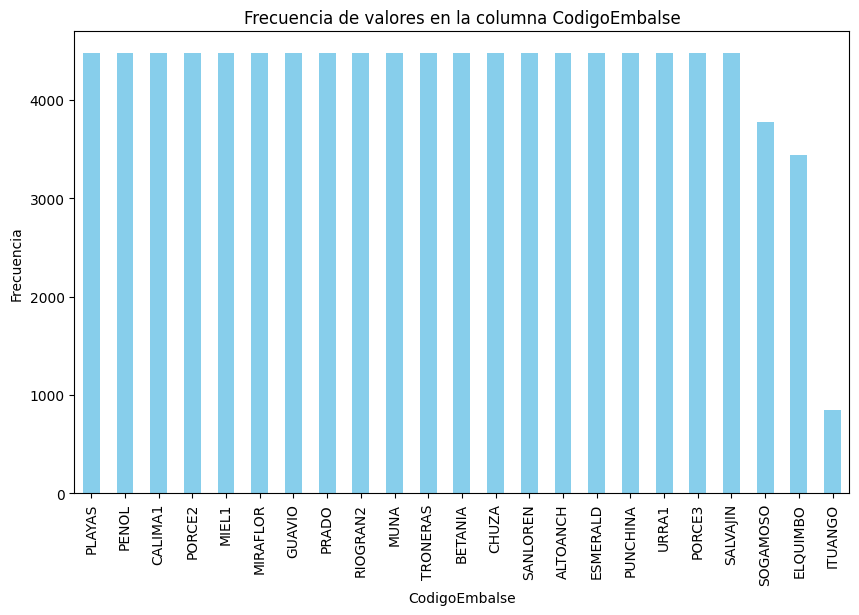

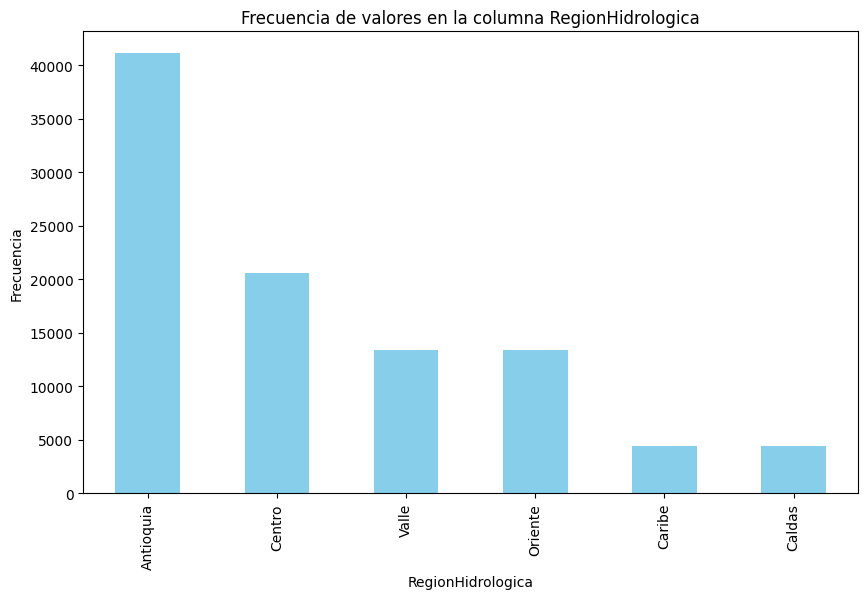

In [9]:
import matplotlib.pyplot as plt

# Realizar un análisis de las variables cualitativas del DataFrame y mostrar diagramas de frecuencia
categorical_columns = data.select_dtypes(include=['object']).columns

for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    data[col].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Frecuencia de valores en la columna {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()


#### **Analisis de estacionalidad en la serie de tiempo:**

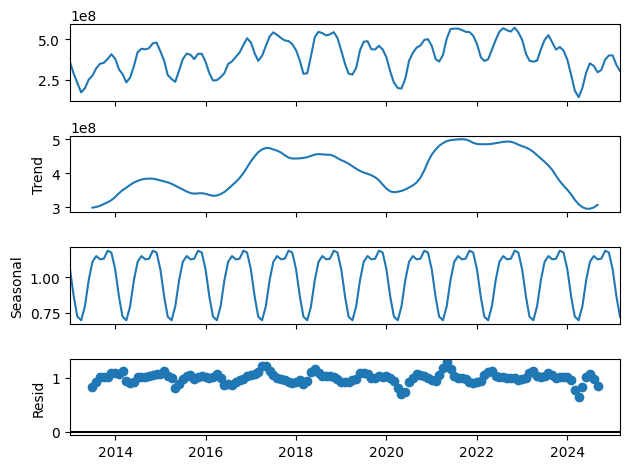

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import date

grouped_data = data.groupby(data['Fecha'].dt.to_period('M')).agg({
    'VolumenUtilDiarioEnergia': 'mean',
    'CapacidadUtilEnergia': 'max',
    'VertimientosEnergia': 'sum',
    'VolumenTotalEnergia': 'sum'
}).reset_index()
grouped_data['Fecha'] = grouped_data['Fecha'].dt.to_timestamp()
decomposition = seasonal_decompose(grouped_data[['Fecha','VolumenUtilDiarioEnergia']].set_index('Fecha'), model='additive')
decomposition.plot()
plt.show()

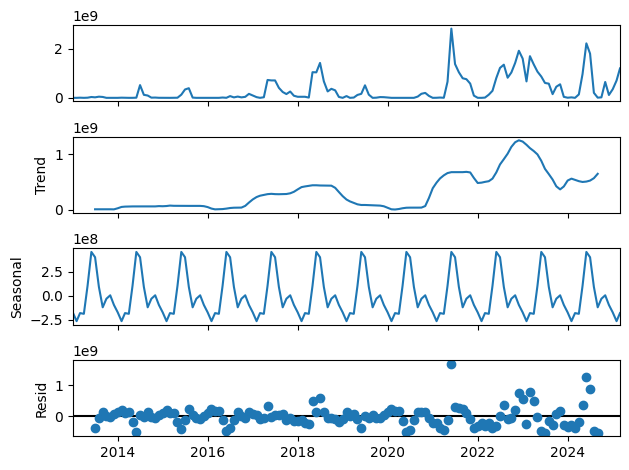

In [36]:
decomposition = seasonal_decompose(grouped_data[['Fecha','VertimientosEnergia']].set_index('Fecha'), model='additive')
decomposition.plot()
plt.show()

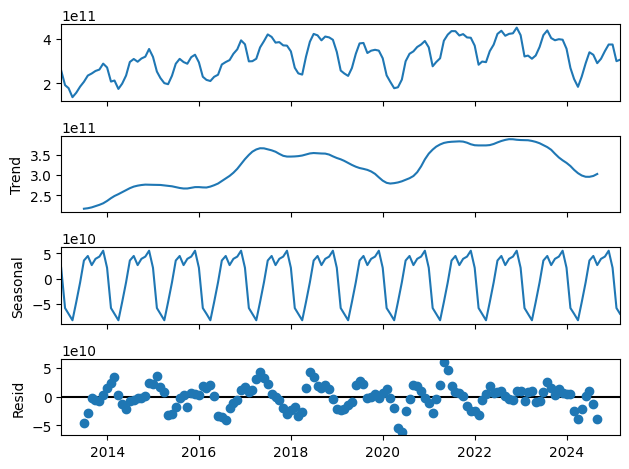

In [37]:
decomposition = seasonal_decompose(grouped_data[['Fecha','VolumenTotalEnergia']].set_index('Fecha'), model='additive')
decomposition.plot()
plt.show()

### **Aportes Hídricos en Energía:**

| Columna | Descripción | Tipo de dato |
|---------|-------------|--------------|
|   Fecha  |  Fecha de representación de la información           |    Date         |
|   CodigoSerieHidrologica   |  Código único para identificar una serie hidrologica o un río del Sistema Interconectado Nacional  |       str       |
|   RegionHidrologica   |  Zona geográfica en la cual se agrupan elementos con características hidrológicas similares.  |       str       |
|   AportesHidricosEnergia   |  	Aporte hídrico asociado con un recurso de generación despachado centralmente. |       float       |
|   PromedioAcumuladoEnergia  |  Aportes hidricos promedio para lo que va corrido del mes.  |       float       |
|   MediaHistoricaEnergia   |  	Promedio mensual multianual de la serie hidrológica aprobada por Acuerdo CNO  |       float       |



##### **Cargar conjuntos de datos de historicos:**

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo de datos
data = pd.read_excel("D:\mis documentos\Personal\Repos\JSSL-INV-FUNC-BACKEND\Data\SIMEM\AportesHidricos.xlsx")
data['Fecha'] = pd.to_datetime(data['Fecha'])
# Mostrar las primeras filas del DataFrame
data.head()

,Fecha,CodigoSerieHidrologica,RegionHidrologica,AportesHidricosEnergia,PromedioAcumuladoEnergia,MediaHistoricaEnergia
0,2013-05-31,FLR2CAUC,Valle,383400,200000.0,310000.0
1,2013-05-31,URR1SINU,Caribe,4044200,4860000.0,4800000.0
2,2013-05-31,PP-2PORC,Antioquia,16672400,15000000.0,11980000.0
3,2013-05-31,BOCATENC,Antioquia,1107500,1770000.0,2410000.0
4,2013-05-31,PTEHMIEL,Caldas,4996600,5180000.0,4550000.0


#### **Descripción de variables numericas:**

In [95]:
data.describe()

,Fecha,AportesHidricosEnergia,PromedioAcumuladoEnergia,MediaHistoricaEnergia
count,152505,1.525050e+05,1.517880e+05,1.520260e+05
mean,2019-10-19 00:30:14.623783168,9.365653e+06,9.345590e+06,1.008390e+07
min,2013-05-01 00:00:00,0.000000e+00,0.000000e+00,5.000000e+04
25%,2016-10-31 00:00:00,6.405000e+05,7.500000e+05,1.110000e+06
50%,2020-01-04 00:00:00,2.389700e+06,2.540000e+06,3.280000e+06
75%,2022-11-28 00:00:00,6.288500e+06,6.710000e+06,7.310000e+06
max,2025-05-01 00:00:00,6.434042e+08,5.217400e+08,2.880500e+08
std,NaN,3.049428e+07,2.929748e+07,3.027412e+07


#### **Descripción de variables categoricas:**

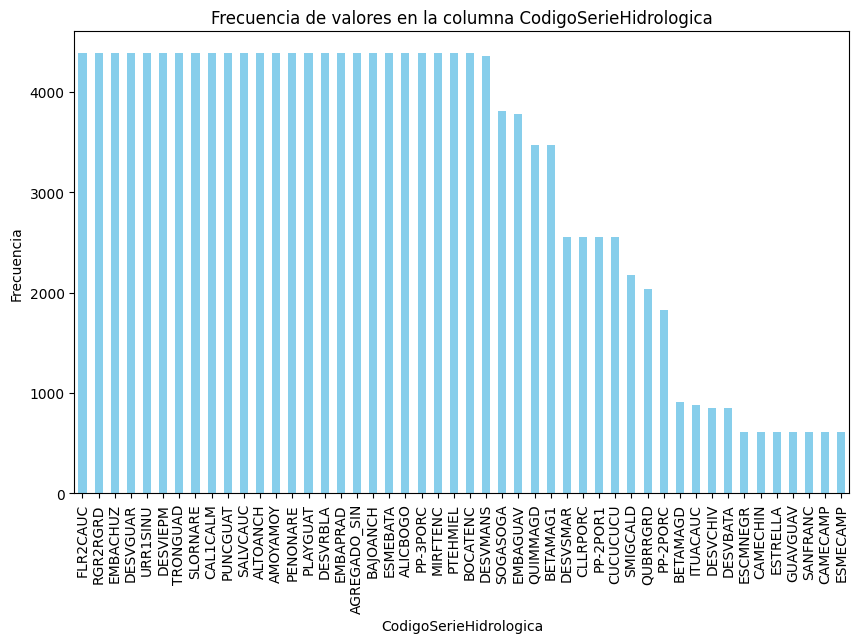

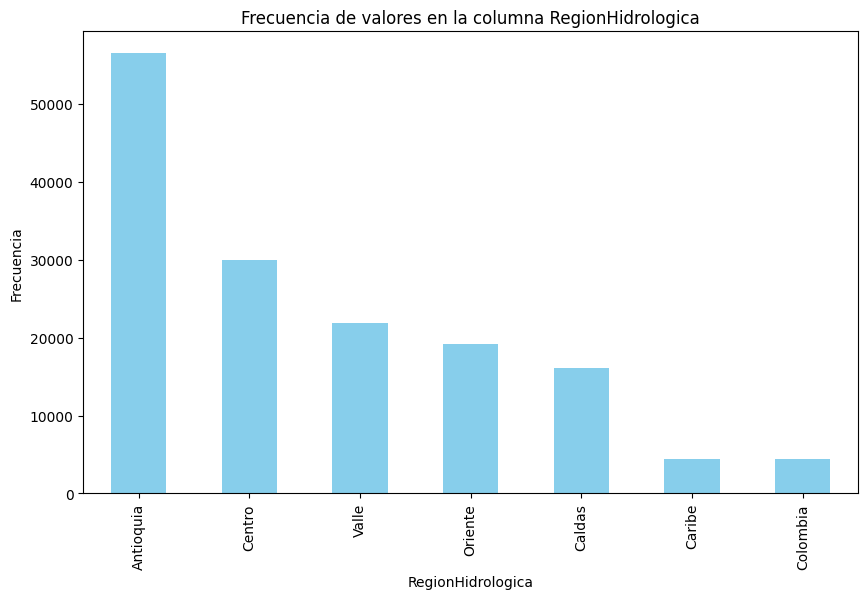

In [96]:
import matplotlib.pyplot as plt

# Realizar un análisis de las variables cualitativas del DataFrame y mostrar diagramas de barras
categorical_columns = data.select_dtypes(include=['object']).columns

for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    data[col].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Frecuencia de valores en la columna {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()


#### **Datos faltantes:**

In [97]:
data['PromedioAcumuladoEnergia'].fillna(method='ffill', inplace=True)
data['MediaHistoricaEnergia'].fillna(method='bfill', inplace=True)

data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152505 entries, 0 to 152504
Data columns (total 6 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Fecha                     152505 non-null  datetime64[ns]
 1   CodigoSerieHidrologica    152505 non-null  object        
 2   RegionHidrologica         152505 non-null  object        
 3   AportesHidricosEnergia    152505 non-null  int64         
 4   PromedioAcumuladoEnergia  152505 non-null  float64       
 5   MediaHistoricaEnergia     152505 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 7.0+ MB


#### **Analisis de estacionalidad en la serie de tiempo:**

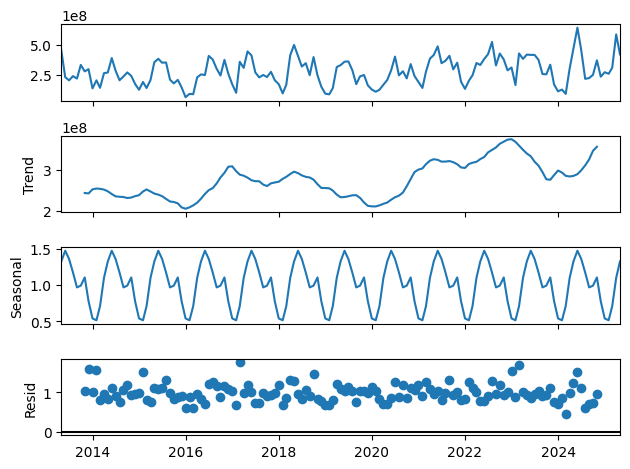

In [98]:
from statsmodels.tsa.seasonal import seasonal_decompose
data['Fecha'] = pd.to_datetime(data['Fecha'])
grouped_data = data.groupby(data['Fecha'].dt.to_period('M')).agg({
    'AportesHidricosEnergia': 'max',
    'PromedioAcumuladoEnergia': 'mean',
    'MediaHistoricaEnergia': 'mean'
   
}).reset_index()
grouped_data['Fecha'] = grouped_data['Fecha'].dt.to_timestamp()
decomposition = seasonal_decompose(grouped_data[['Fecha','AportesHidricosEnergia']].set_index('Fecha'), model='multiplicative')
decomposition.plot()
plt.show()

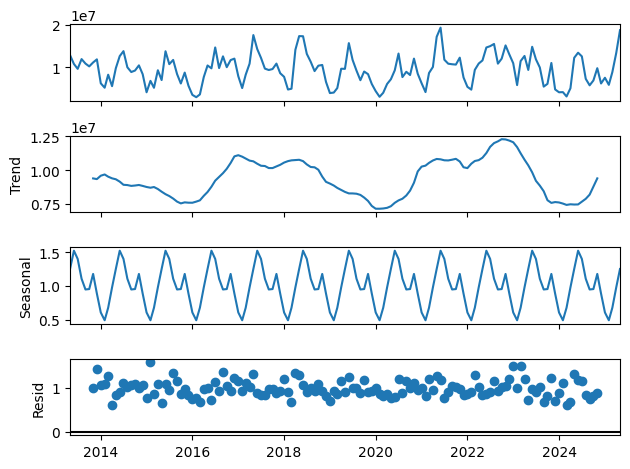

In [99]:
decomposition = seasonal_decompose(grouped_data[['Fecha','PromedioAcumuladoEnergia']].set_index('Fecha'), model='multiplicative')
decomposition.plot()
plt.show()

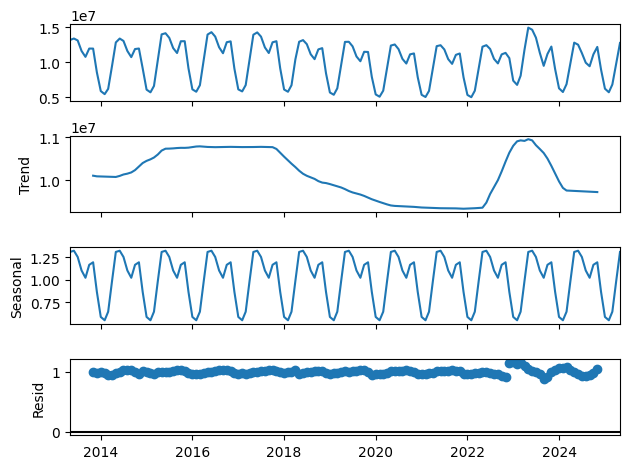

In [100]:
decomposition = seasonal_decompose(grouped_data[['Fecha','MediaHistoricaEnergia']].set_index('Fecha'), model='multiplicative')
decomposition.plot()
plt.show()

## **Transformación de datos:**

Para obtener el detalle de como se realizan las transformaciones revisar el archivo <code>src\README.md</code> o el script <code>src\Analysis\TransformData.py</code>

In [2]:
oni_path = '../../Data/Cleansed/ONI/ONI_historico.xlsx'
paratec_path = '../../Data/Cleansed/PARATEC/PARATEC_2025-05-17.xlsx'
simem_reservas_path = '../../Data/Cleansed/SIMEM/ReservasHidraulicasEnergía.xlsx'
simem_aportes_path = '../../Data/Cleansed/SIMEM/AportesHidricos.xlsx'
simem_embalses_path = '../../Data/Cleansed/SIMEM/ListadoEmbalses.xlsx'
join_data = JoinData(oni_path, paratec_path, simem_reservas_path, simem_aportes_path, simem_embalses_path)

join_data.save_data_not_agregate(stale=True)
join_data.save_data_agregate(stale=True)


Index(['VolumenUtilDiarioEnergia', 'CapacidadUtilEnergia',
       'VolumenTotalEnergia', 'VertimientosEnergia', 'SST', 'ANOM',
       'AportesHidricosEnergia', 'PromedioAcumuladoEnergia',
       'MediaHistoricaEnergia', 'Dia', 'Mes', 'Año',
       'RegionHidrologica_Antioquia', 'RegionHidrologica_Caldas',
       'RegionHidrologica_Caribe', 'RegionHidrologica_Centro',
       'RegionHidrologica_Oriente', 'RegionHidrologica_Valle'],
      dtype='object')


## **Analisis de correlacion:**

### **Variables agregadas**

In [3]:
# Cargar el archivo de datos

data_not_not_agg = pd.read_excel("../../Data/Results/NotStandardized/EmbalsesNoAgregados.xlsx")
data_not_agg = pd.read_excel("../../Data/Results/NotStandardized/EmbalsesAgregados.xlsx")



### **Correlación lineal:** 

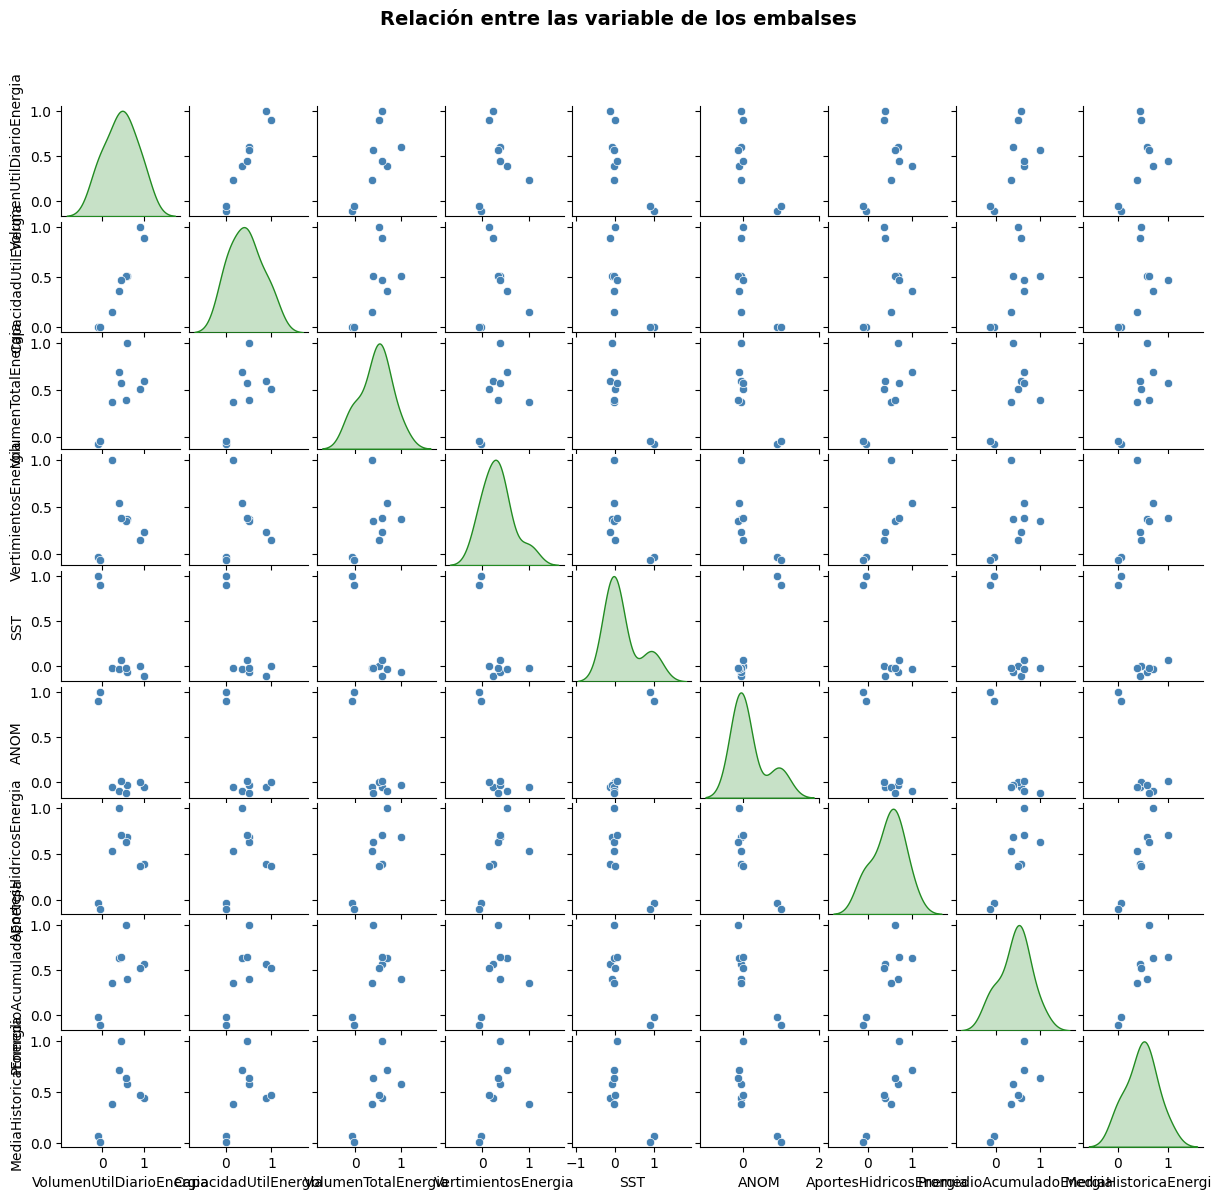

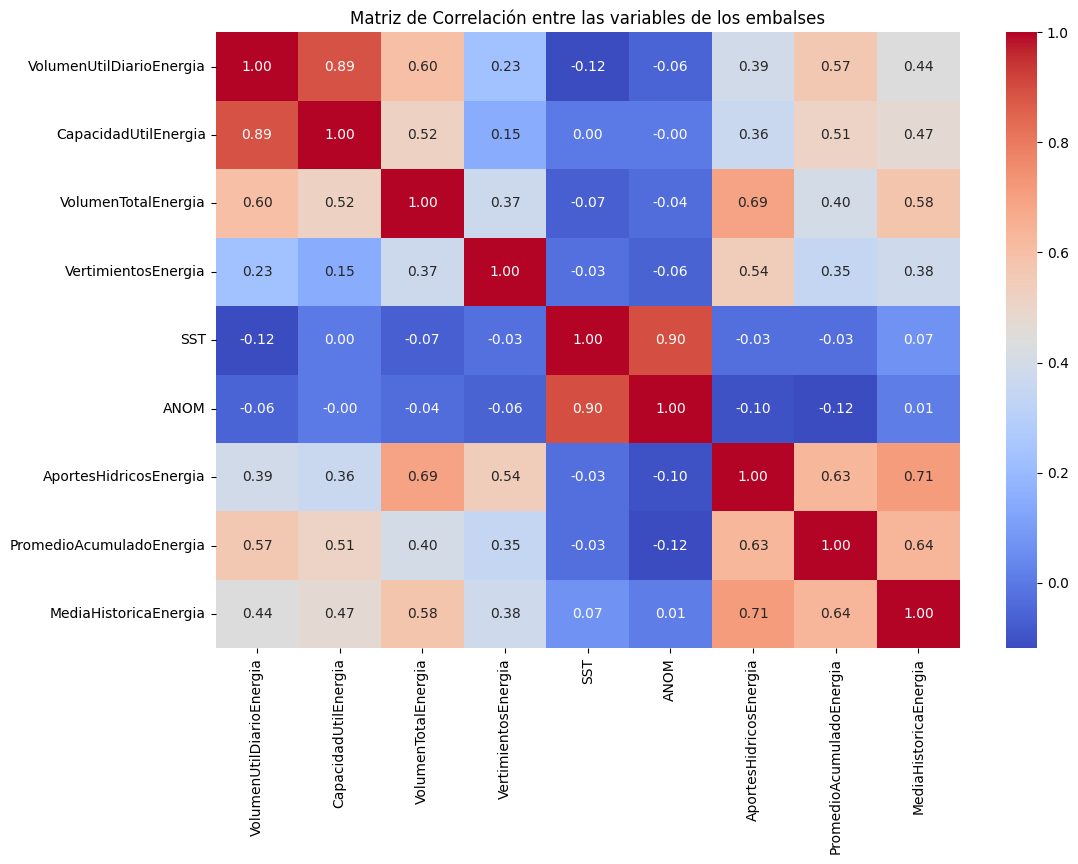

In [8]:
correlation_data = data_not_agg.corr()

# Creacion de grafico de dispersión
multiple_plot(2, correlation_data , correlation_data.select_dtypes(include = ['float64','int32','int64']).columns.tolist(), None, 'scatterplot', 'Relación entre las variable de los embalses',0)

# Graficar Matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación entre las variables de los embalses')
plt.show()


### **Correlación cruzada entre ONI y Capacidad util de los embalses:** 

[-0.11699161 -0.116959   -0.11696078 ...  0.06494583  0.03963879
  0.58766603]


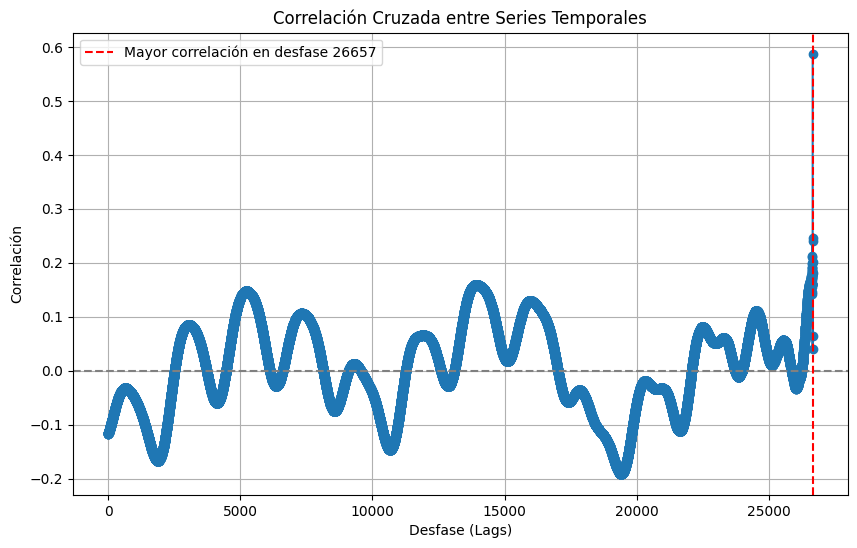

[-0.05730114 -0.05740552 -0.05744646 ...  0.03890154  0.02374302
  0.35200286]


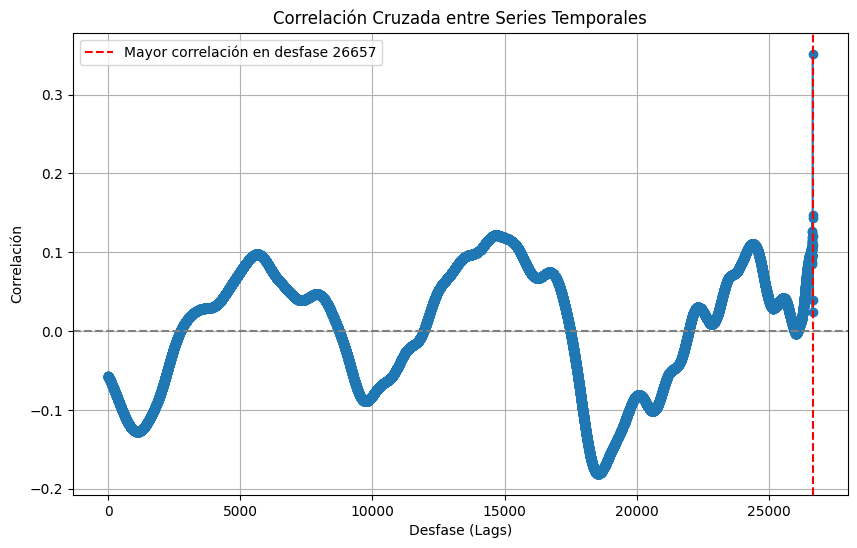

In [9]:

import seaborn as sns
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt
import numpy as np


data_not_agg['Fecha'] = data_not_agg['Dia'].astype(str) + '-' + data_not_agg['Mes'].astype(str) + '-' + data_not_agg['Año'].astype(str)   
data_not_agg['Fecha'] = pd.to_datetime(data_not_agg['Fecha'], format='%d-%m-%Y')
data_not_agg.set_index('Fecha', inplace=True)

# Calcular la correlación cruzada entre las dos series temporales
cross_corr = ccf(data_not_agg['VolumenUtilDiarioEnergia'], data_not_agg['SST'])
print(cross_corr)


# Crear el eje de desfases
lags = np.arange(len(cross_corr))


# Graficar
plt.figure(figsize=(10, 6))
plt.plot(lags, cross_corr, marker='o')
plt.xlabel('Desfase (Lags)')
plt.ylabel('Correlación')
plt.title('Correlación Cruzada entre Series Temporales')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(lags[np.argmax(cross_corr)], color='red', linestyle='--', label=f'Mayor correlación en desfase {lags[np.argmax(cross_corr)]}')
plt.legend()
plt.grid(True)
plt.show()

# Calcular la correlación cruzada entre las dos series temporales
cross_corr = ccf(data_not_agg['VolumenUtilDiarioEnergia'], data_not_agg['ANOM'])
print(cross_corr)


# Crear el eje de desfases
lags = np.arange(len(cross_corr))


# Graficar
plt.figure(figsize=(10, 6))
plt.plot(lags, cross_corr, marker='o')
plt.xlabel('Desfase (Lags)')
plt.ylabel('Correlación')
plt.title('Correlación Cruzada entre Series Temporales')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(lags[np.argmax(cross_corr)], color='red', linestyle='--', label=f'Mayor correlación en desfase {lags[np.argmax(cross_corr)]}')
plt.legend()
plt.grid(True)
plt.show()



### **Correlación dinamica entre ONI y Capacidad util de los embalses:**

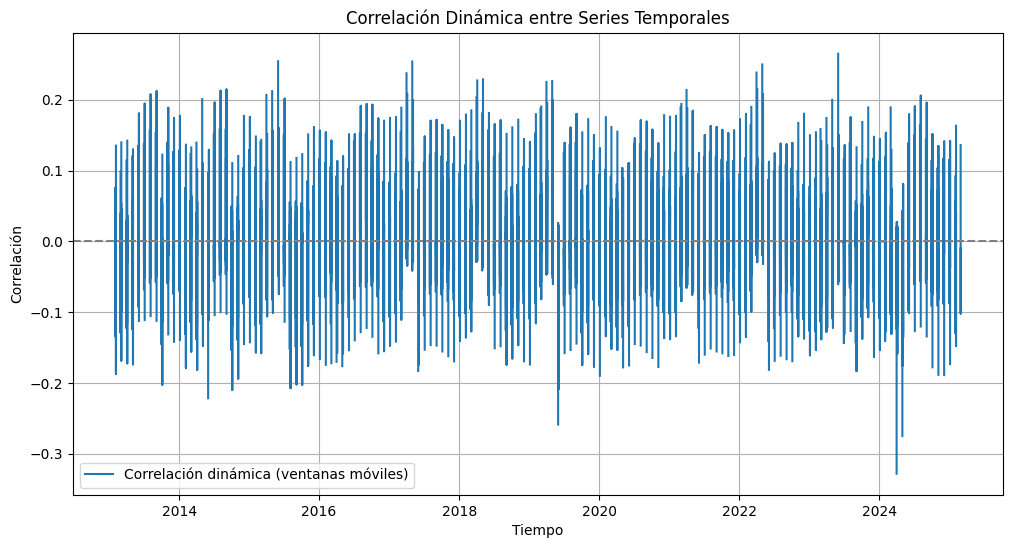

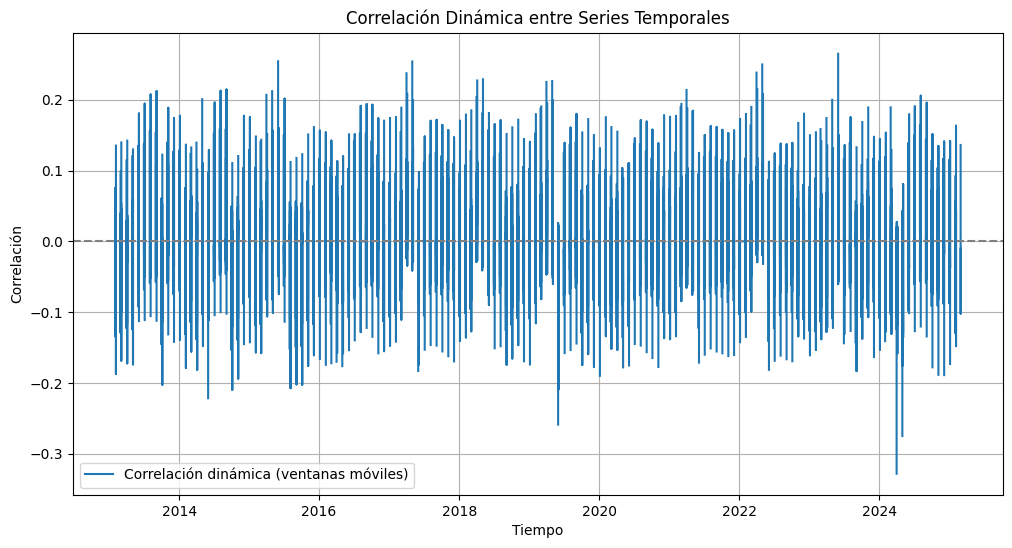

In [10]:

window_size = 30
rolling_corr = data_not_agg['VolumenUtilDiarioEnergia'].rolling(window=window_size).corr(data_not_agg['SST'].apply(lambda x: x - data_not_agg['SST'].mean()))

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(data_not_agg.index, rolling_corr, label='Correlación dinámica (ventanas móviles)')
plt.xlabel('Tiempo')
plt.ylabel('Correlación')
plt.title('Correlación Dinámica entre Series Temporales')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

rolling_corr = data_not_agg['VolumenUtilDiarioEnergia'].rolling(window=window_size).corr(data_not_agg['SST'].apply(lambda x: x - data_not_agg['ANOM'].mean()))

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(data_not_agg.index, rolling_corr, label='Correlación dinámica (ventanas móviles)')
plt.xlabel('Tiempo')
plt.ylabel('Correlación')
plt.title('Correlación Dinámica entre Series Temporales')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()


### **Granger Causality entre ONI y Capacidad util de los embalses**

In [12]:
# Se utiliza el Granger Causality para validar si el ONI es un predictor del VolumenUtilDiarioEnergia para ellos es necesario que los 5 p-valores sean menores a 0.05

granger_result= grangercausalitytests(data_not_agg[['VolumenUtilDiarioEnergia', 'ANOM']], maxlag=5, verbose=False)


max_lag = 5

# Crear un DataFrame con los p-valores para cada desfase
p_values = []
for lag in range(1, max_lag + 1):
    f_pvalue = granger_result[lag][0]['ssr_ftest'][1]
    p_values.append(f_pvalue)

p_values_df_1 = pd.DataFrame({'Lag': range(1, max_lag + 1), 'P-Value': p_values})


granger_result= grangercausalitytests(data_not_agg[['VolumenUtilDiarioEnergia', 'SST']], maxlag=5, verbose=False)


max_lag = 5

# Crear un DataFrame con los p-valores para cada desfase
p_values = []
for lag in range(1, max_lag + 1):
    f_pvalue = granger_result[lag][0]['ssr_ftest'][1]
    p_values.append(f_pvalue)

p_values_df = pd.DataFrame({'Lag': range(1, max_lag + 1), 'P-Value': p_values})
p_values_df


,Lag,P-Value
0,1,1.906203e-136
1,2,7.514424e-142
2,3,4.508298e-183
3,4,1.872790e-191
4,5,0.000000e+00


In [13]:
p_values_df_1

,Lag,P-Value
0,1,1.335168e-33
1,2,1.515807e-33
2,3,1.771608e-41
3,4,1.160598e-41
4,5,1.262924e-71


### ***Variables no agregadas:***

### **Correlación lineal:**

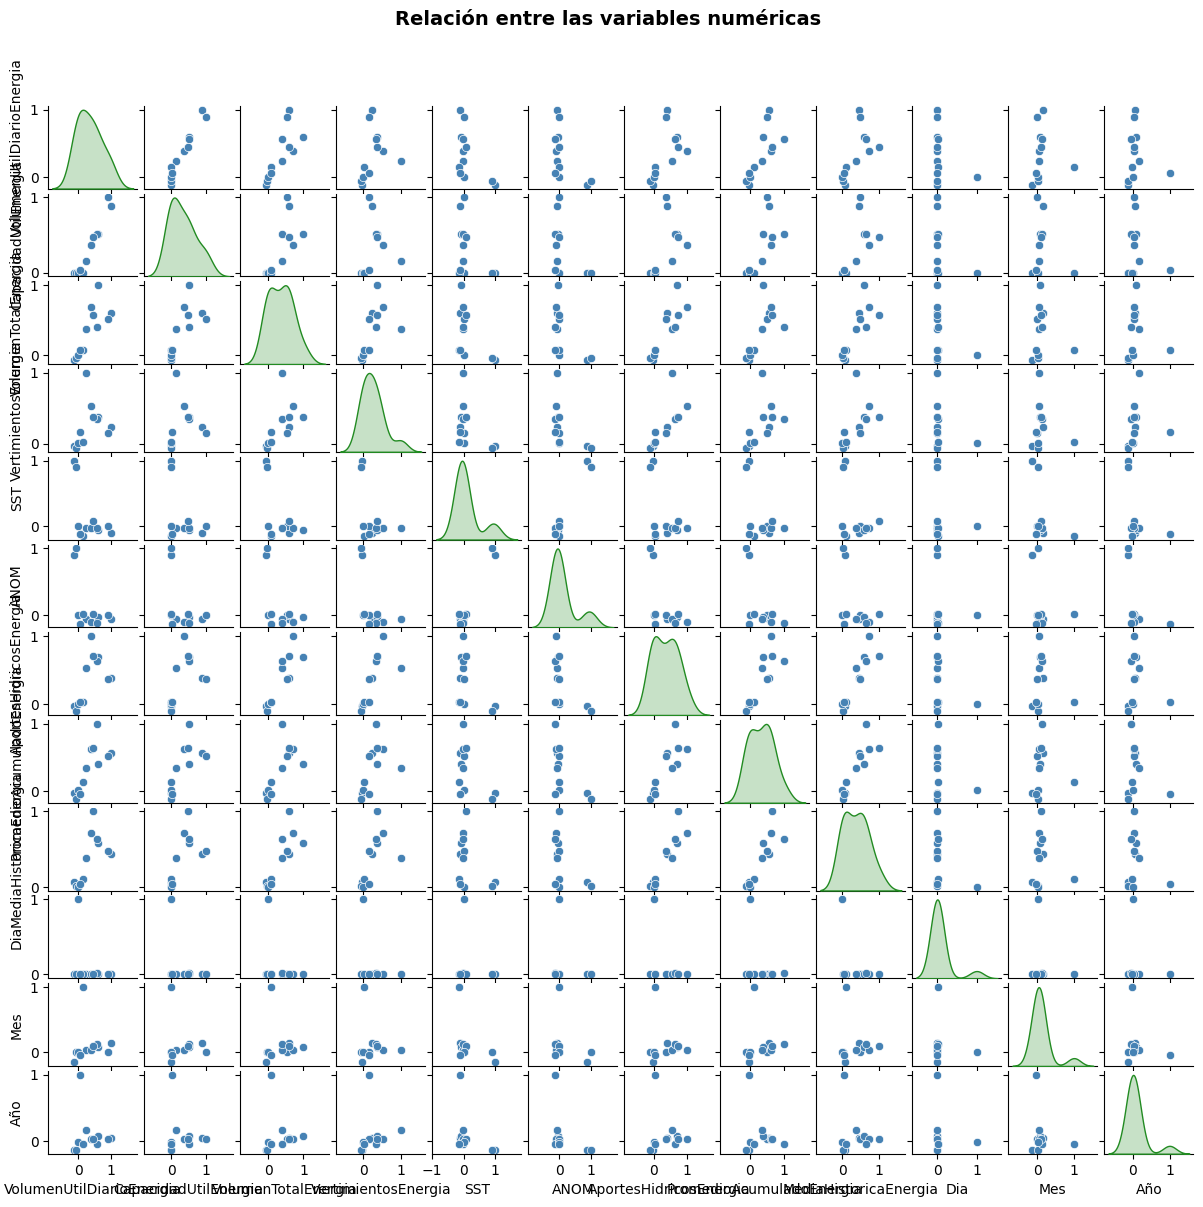

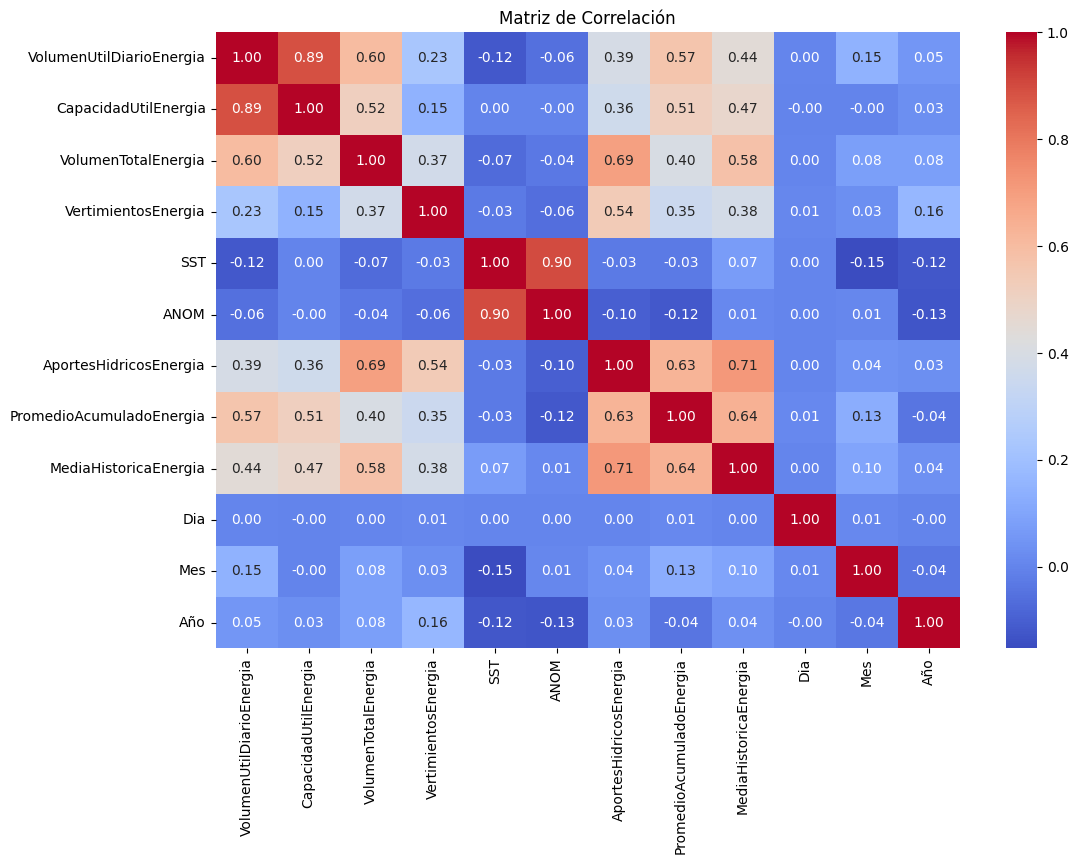

In [4]:
correlation_data = data_not_agg.corr()
multiple_plot(2, correlation_data , correlation_data.select_dtypes(include = ['float64','int32','int64']).columns.tolist(), None, 'scatterplot', 'Relación entre las variables numéricas',0)

# Pintar la matriz de correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

### **Correlación cruzada:**

[-0.05810323 -0.05803851 -0.05808289 ...  0.30811368  0.45087799
  0.40237429]


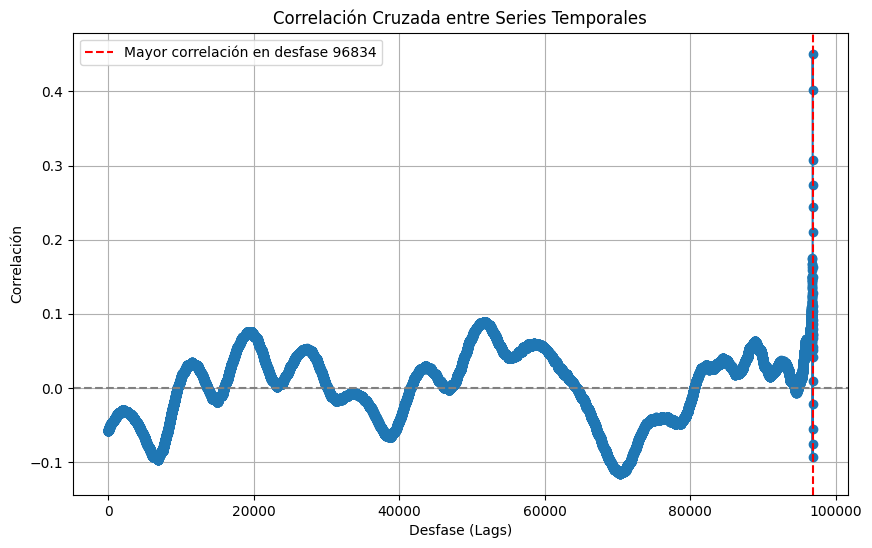

[-0.03125475 -0.03120987 -0.03121129 ...  0.18498928  0.27070396
  0.24158268]


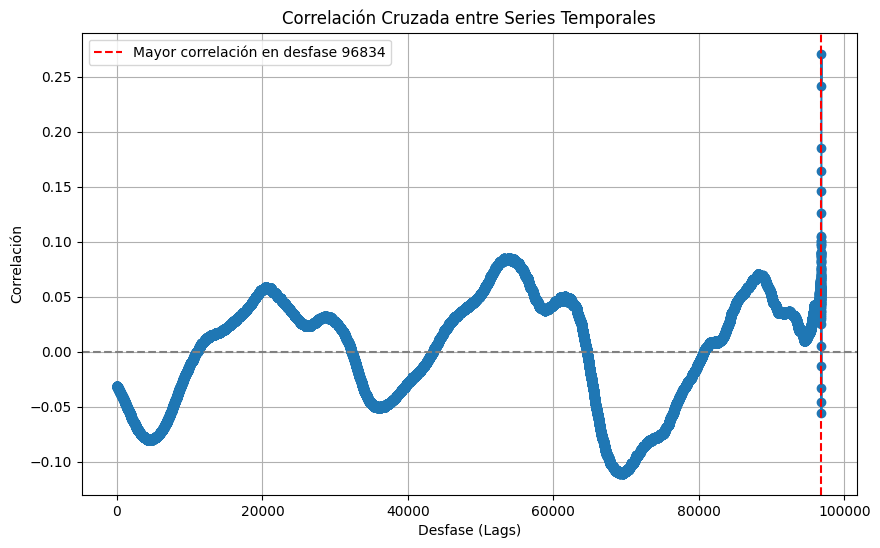

In [63]:

import seaborn as sns
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt
import numpy as np


data_not_not_agg['Fecha'] = data_not_not_agg['Dia'].astype(str) + '-' + data_not_not_agg['Mes'].astype(str) + '-' + data_not_not_agg['Año'].astype(str)   
data_not_not_agg['Fecha'] = pd.to_datetime(data_not_not_agg['Fecha'], format='%d-%m-%Y')
data_not_not_agg.set_index('Fecha', inplace=True)

# Calcular la correlación cruzada entre las dos series temporales
cross_corr = ccf(data_not_not_agg['VolumenUtilDiarioEnergia'], data_not_not_agg['SST'])
print(cross_corr)


# Crear el eje de desfases
lags = np.arange(len(cross_corr))


# Graficar
plt.figure(figsize=(10, 6))
plt.plot(lags, cross_corr, marker='o')
plt.xlabel('Desfase (Lags)')
plt.ylabel('Correlación')
plt.title('Correlación Cruzada entre Series Temporales')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(lags[np.argmax(cross_corr)], color='red', linestyle='--', label=f'Mayor correlación en desfase {lags[np.argmax(cross_corr)]}')
plt.legend()
plt.grid(True)
plt.show()

# Calcular la correlación cruzada entre las dos series temporales
cross_corr = ccf(data_not_not_agg['VolumenUtilDiarioEnergia'], data_not_not_agg['ANOM'])
print(cross_corr)


# Crear el eje de desfases
lags = np.arange(len(cross_corr))


# Graficar
plt.figure(figsize=(10, 6))
plt.plot(lags, cross_corr, marker='o')
plt.xlabel('Desfase (Lags)')
plt.ylabel('Correlación')
plt.title('Correlación Cruzada entre Series Temporales')
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(lags[np.argmax(cross_corr)], color='red', linestyle='--', label=f'Mayor correlación en desfase {lags[np.argmax(cross_corr)]}')
plt.legend()
plt.grid(True)
plt.show()

### **Correlación dinamica:**

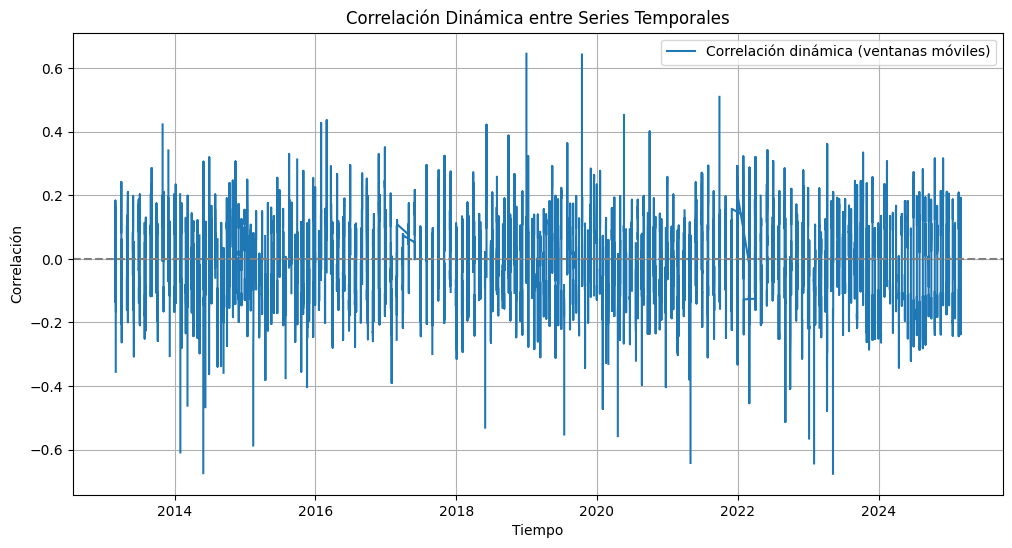

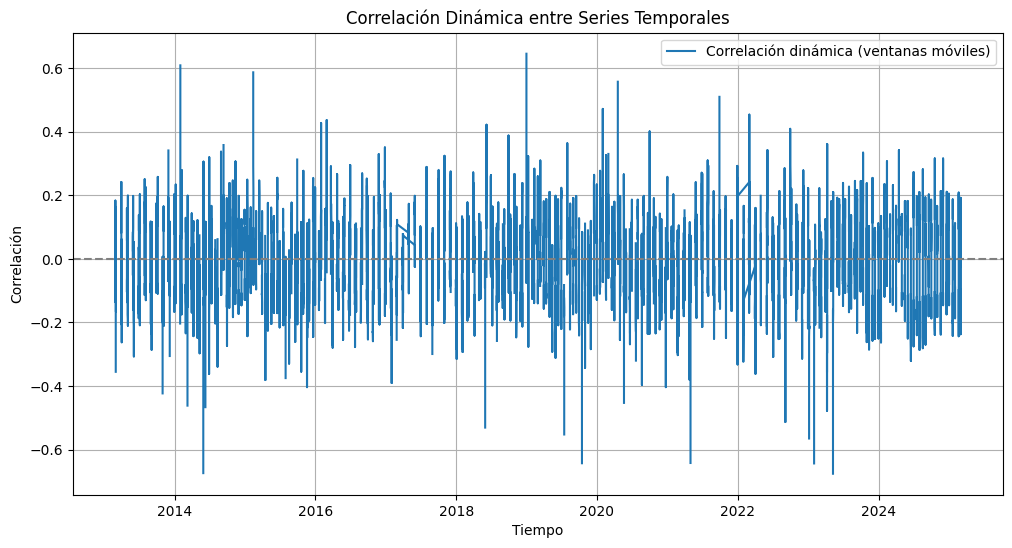

In [65]:

window_size = 30
rolling_corr = data_not_not_agg['VolumenUtilDiarioEnergia'].rolling(window=window_size).corr(data_not_not_agg['SST'])

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(data_not_not_agg.index, rolling_corr, label='Correlación dinámica (ventanas móviles)')
plt.xlabel('Tiempo')
plt.ylabel('Correlación')
plt.title('Correlación Dinámica entre Series Temporales')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()


window_size = 30
rolling_corr = data_not_not_agg['VolumenUtilDiarioEnergia'].rolling(window=window_size).corr(data_not_not_agg['ANOM'])

# Graficar
plt.figure(figsize=(12, 6))
plt.plot(data_not_not_agg.index, rolling_corr, label='Correlación dinámica (ventanas móviles)')
plt.xlabel('Tiempo')
plt.ylabel('Correlación')
plt.title('Correlación Dinámica entre Series Temporales')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()

### **Granger Causality:**

In [66]:
from statsmodels.tsa.stattools import grangercausalitytests
import pandas as pd

# Se utiliza el Granger Causality para validar si el ONI es un predictor del VolumenUtilDiarioEnergia para ellos es necesario que los 5 p-valores sean menores a 0.05

granger_result= grangercausalitytests(data_not_not_agg[['VolumenUtilDiarioEnergia', 'SST']], maxlag=5, verbose=False)


max_lag = 5

# Crear un DataFrame con los p-valores para cada desfase
p_values = []
for lag in range(1, max_lag + 1):
    f_pvalue = granger_result[lag][0]['ssr_ftest'][1]
    p_values.append(f_pvalue)

p_values_df = pd.DataFrame({'Lag': range(1, max_lag + 1), 'P-Value': p_values})
p_values_df

,Lag,P-Value
0,1,3.990965e-76
1,2,1.969621e-77
2,3,7.123266e-75
3,4,2.054907e-76
4,5,9.191615e-75


In [67]:
# Se utiliza el Granger Causality para validar si el ONI es un predictor del VolumenUtilDiarioEnergia para ellos es necesario que los 5 p-valores sean menores a 0.05

granger_result= grangercausalitytests(data_not_not_agg[['VolumenUtilDiarioEnergia', 'ANOM']], maxlag=5, verbose=False)


max_lag = 5

# Crear un DataFrame con los p-valores para cada desfase
p_values = []
for lag in range(1, max_lag + 1):
    f_pvalue = granger_result[lag][0]['ssr_ftest'][1]
    p_values.append(f_pvalue)

p_values_df = pd.DataFrame({'Lag': range(1, max_lag + 1), 'P-Value': p_values})
p_values_df

,Lag,P-Value
0,1,3.726594e-23
1,2,9.689741e-23
2,3,2.286880e-21
3,4,2.500032e-21
4,5,2.522875e-20
